<a href="https://colab.research.google.com/github/fedorkrikman/september2025/blob/main/12_2_%D0%97%D0%BD%D0%B0%D0%BA%D0%BE%D0%BC%D1%81%D1%82%D0%B2%D0%BE_%D1%81_%D0%B1%D0%B8%D0%B1%D0%BB%D0%B8%D0%BE%D1%82%D0%B5%D0%BA%D0%BE%D0%B9_asyncio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

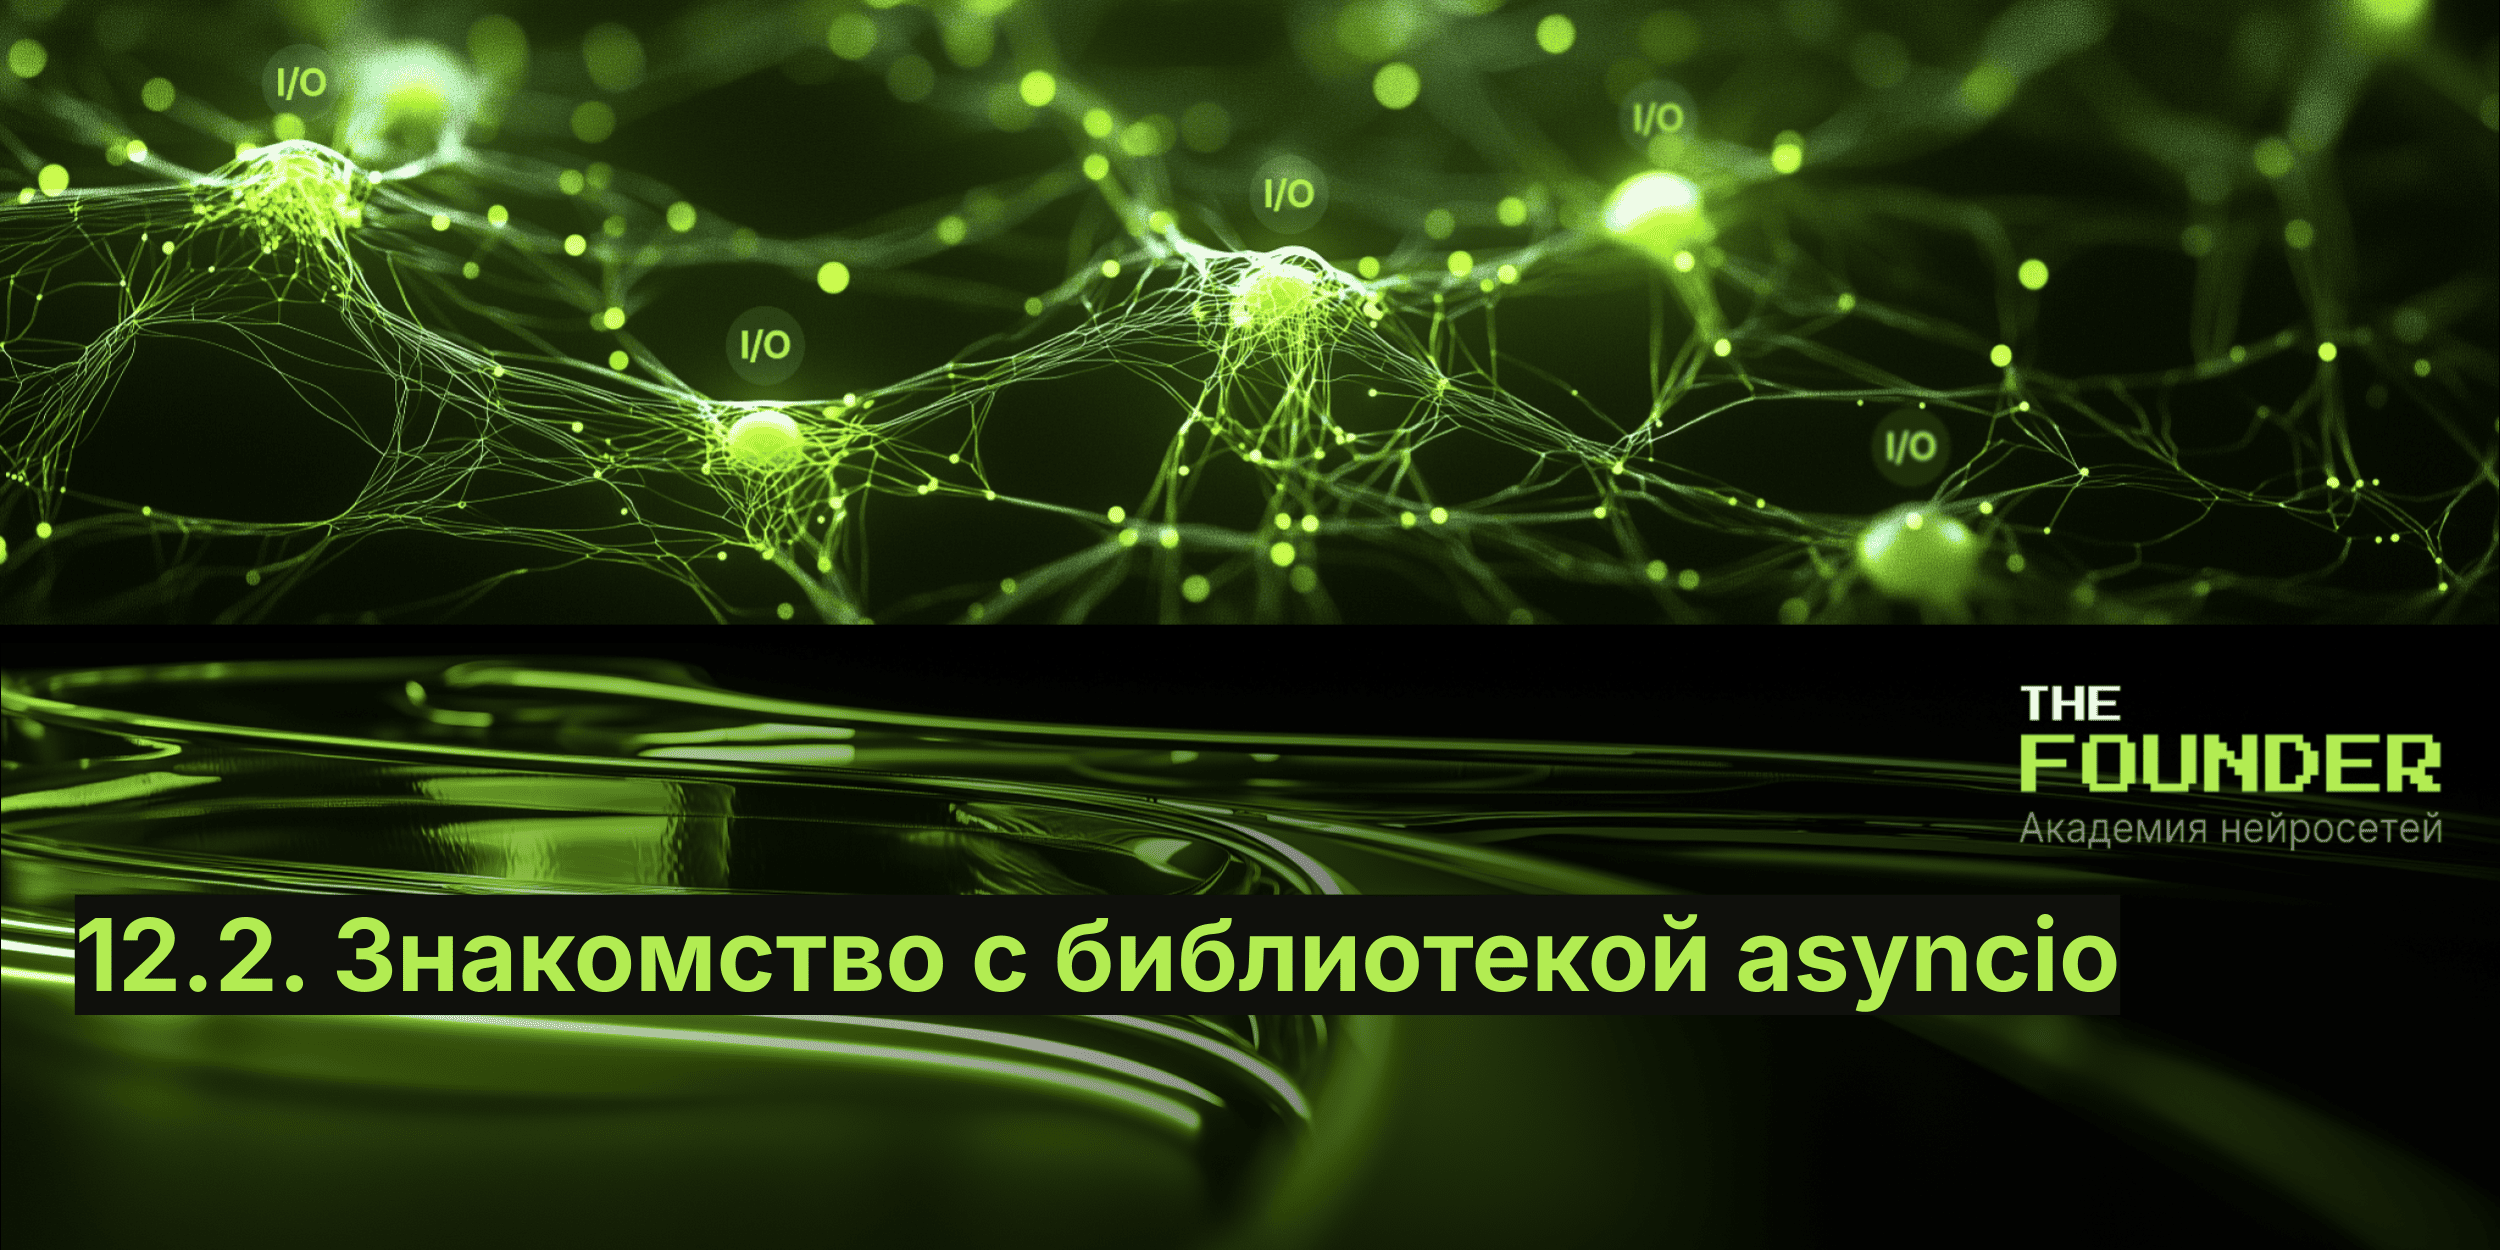

**Навигация по уроку**

1. [Введение в асинхронное программирование](https://colab.research.google.com/drive/1UavHM4i_kgjmdoMxvxac6LuPfVaBXHNA)
2. Знакомство с библиотекой asyncio
3. [Создание Telegram-бота с использованием aiogram3 и BotFather](https://colab.research.google.com/drive/1bgS8Uuqi2jrhqDAyaMmxhbOLJ3TvmKFC)
4. [Домашняя работа](https://colab.research.google.com/drive/1ylF61osqEgPqg4KgfmikbKMAyalhjBqv)

В данном уроке мы продолжим погружение в мир асинхронного программирования на более практическом уровне, изучим библиотеку `asyncio`, а также основные паттерны, которые она использует.

В прошлом Блокноте мы задались вопросом: "А как же нам отличить задачи, ожидающие завершения ввода-вывода, от тех, которые просто выполняют Python-код и которые ничего не ждут?"

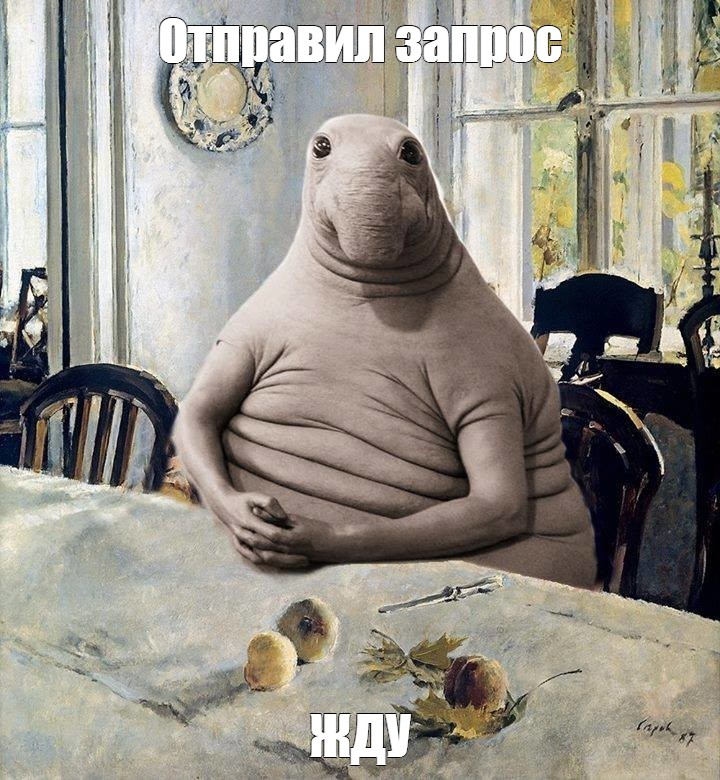

Ответ дает конструкция под названием «цикл событий», о которой мы сейчас и поговорим.

## Как работает цикл событий?

Цикл событий – сердце любого приложения asyncio. Этот паттерн проектирования встречается во многих системах и  был придуман уже довольно давно.

Например:
* В `JavaScript` для отправки асинхронного запроса, необходимо создать задачу, управляемую циклом событий.
* В GUI-приложениях Windows используются так называемые циклы обработки сообщений. Это основной механизм обработки таких событий, как нажатие клавиш, он позволяет одновременно отрисовывать интерфейс и реагировать на действия пользователя.

По сути своей цикл событий очень прост. Мы создаем очередь, в которой хранится список событий или сообщений, а затем входим в бесконечный цикл, где обрабатываем сообщения по мере их поступления.

В `asyncio`цикл событий управляет очередью задач, а не сообщений.

Задача – это обертка вокруг сопрограммы.

Сопрограмма может приостановить выполнение, встретив операцию ввода-вывода, и дать циклу событий возможность выполнить другие задачи, которые не ждут
завершения ввода-вывода.

Чуть ниже мы подробно рассмотрим сопрограммы и станет понятнее.

Создавая цикл событий, мы создаем пустую очередь задач. Затем добавляем в  эту очередь задачи для выполнения. На каждой итерации цикла проверяется, есть ли в очереди готовая задача, и если да, то она выполняется, пока не встретит операцию ввода-вывода.


В этот момент задача приостанавливается, и мы просим операционную систему наблюдать за ее устройствами ввода-вывода. А сами тем временем переходим к следующей готовой задаче. На каждой итерации проверяется, завершилась ли какая-нибудь операция ввода-вывода. Если да, то ожидавшие ее завершения задачи пробуждаются и им предоставляется возможность продолжить работу.

Эта идея иллюстрируется на рис. 1, где главный поток поставляет задачи циклу событий, а тот их выполняет.


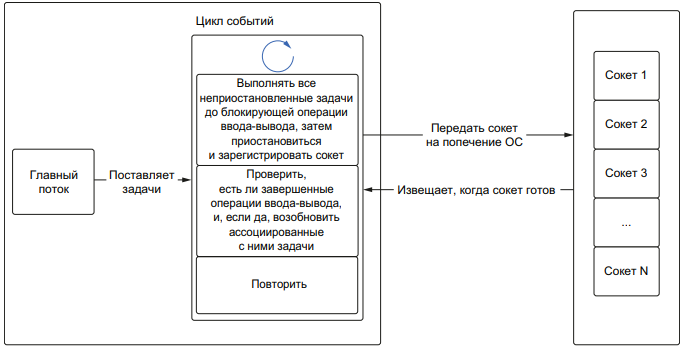

**Рис. 1. Пример потока, который поставляет задачи циклу событий**




Для конкретики представим, что имеется три задачи, каждая из которых отправляет асинхронный веб-запрос. Допустим, что на этапе инициализации они выполняют некоторый счетный код, затем посылают веб-запрос, а по его завершении обрабатывают результат, что снова требуется счет. На псевдокоде это выглядит так:

```python
def make_request():
  cpu_bound_setup()
  io_bound_web_request()
  cpu_bound_postprocess()
  
task_one = make_request()
task_two = make_request()
task_three = make_request()
```

Все три задачи вначале выполняют счетные операции, а поскольку поток всего один, то первая задача начинает работать, а остальные две ждут. Закончив счетную часть, задача 1 встречает операцию ввода-вывода и приостанавливается со словами: «Я жду завершения ввода-вывода, пусть поработают другие». После этого начинает работать задача 2 и, встретив операцию ввода-вывода, тоже приостанавливается. В этот момент обе задачи, 1 и 2, ждут завершения ввода-вывода, так что может приступить к работе задача 3.

Теперь допустим, что пока задача 3 ждет завершения своей операции ввода-вывода, пришел ответ на веб-запрос от задачи 1. Операционная система уведомляет нас о том, что ввод-вывод завершен. Мы можем возобновить задачу 1, пока задачи 2 и 3 ждут.

На рис. 2 показан поток выполнения, соответствующий псевдокоду выше. На рисунке видно, что в каждый момент времени работает только один счетный кусок кода, но при этом конкурентно выполняются одна или две операции ввода-вывода. Именно из-за такого перекрытия ожидания ввода-вывода `asyncio` и достигает экономии во времени.

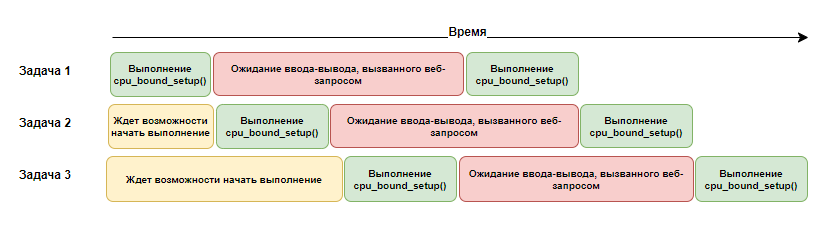

**Рис. 2. Конкурентое выполнение нескольких задач с операциями ввода-вывода**

## Что такое сопрограмма?

**Сопрограмма** - это обычная функция Python, правда наделенная сверхспособностью "уходить в сон", а точнее, приостанавливаться, встретив операцию, для выполнения которой нужно заметное время. По завершении такой длительной операции сопрограмму можно "разбудить", после чего она продолжит выполнение. Пока приостановленная сопрограмма ждет завершения операции, мы можем выполнять другой код. Такое выполнение другого кода во время ожидания и обеспечивает конкурентность внутри приложения. Можно также одновременно выполнять несколько длительных операций, что еще больше повышает производительность приложения.

> Сопрограмму также часто называют **корутиной**. Эти понятия тожественны.

Для создания и приостановки сопрограммы нам придется использовать ключевые слова Python `async` и `await`. Слово `async` определяет сопрограмму, а слово `await` приостанавливает ее на время выполнения длительной операции.


### Создание сопрограмм

Создать сопрограмму так же просто, как обычную функцию Python, только вместо ключевого слова `def` нужно использовать `async def`. Ключевое слово `async` говорит, что это сопрограмма, а не обычная функция.

In [3]:
async def my_coroutine() -> None: # указываем, что функция возвращает тип None, т.е. ничего не возвращает
    print('Hello world!')

Здесь сопрограмма всего лишь печатает сообщение «Hello world!». Она не выполняет никаких длительных операций, просто печатает и возвращает управление. Это значит, что после передачи циклу событий эта сопрограмма будет выполнена немедленно, поскольку никакого блокирующего ввода-вывода нет и ничто не вынуждает ее приостановиться.

Несмотря на простоту синтаксиса, мы создали нечто, весьма отличное от обычной функции Python. Для иллюстрации напишем функцию, которая прибавляет единицу к  целому числу, и  сопрограмму, делающую то же самое, и сравним результаты. Также мы воспользуемся вспомогательной функцией `type`, чтобы узнать типы значений,
возвращаемых сопрограммой и обычной функцией.

In [4]:
async def coroutine_add_one(number: int) -> int: # функция возвращает тип int
    return number + 1

def add_one(number: int) -> int:
    return number + 1

function_result = add_one(1)
coroutine_result = coroutine_add_one(1)

print(f'Результат функции равен {function_result}, а его тип равен {type(function_result)}')
print(f'Результат сопрограммы равен {coroutine_result}, а его тип равен {type(coroutine_result)}')

Результат функции равен 2, а его тип равен <class 'int'>
Результат сопрограммы равен <coroutine object coroutine_add_one at 0x7aca34099300>, а его тип равен <class 'coroutine'>


Обратите внимание, что обычная функция `add_one` исполняется и возвращает управление сразу, а результат – целое число.

Код сопрограммы `coroutine_add_one` не выполняется, а только возвращает объект сопрограммы.

**ВАЖНО**. Сопрограммы не выполняются, если их вызвать напрямую. Вместо этого возвращается объект сопрограммы, который будет выполнен позже.

> Чтобы выполнить сопрограмму, мы должны явно передать ее циклу событий.

Передать сопрограмму в цикл событий можно несколькими способами, например, с помощью функции `asyncio.run`:

In [1]:
import asyncio
async def coroutine_add_one(number: int) -> int:
    return number + 1

result = asyncio.run(coroutine_add_one(1))
print(result)

RuntimeError: asyncio.run() cannot be called from a running event loop

Как мы видим, программа выполнилась с ошибкой. Ошибка означает, что код был запущен в среде, где уже существует активный цикл событий, например, когда вы пытаетесь использовать асинхронные возможности внутри Jupyter Notebook, Google Colab, интерактивного интерпретатора Python, или других сценариев, где цикл событий уже создан.

Чтобы устранить эту проблему, необходимо использовать библиотеку `nest_asyncio` и ее метод `apply()`.


In [2]:
# Установим библиотеку nest_asyncio
!pip install nest_asyncio

import nest_asyncio
nest_asyncio.apply()

Defaulting to user installation because normal site-packages is not writeable



Теперь мы можем выполнить наш пример, с учетом уже существующего активного цикла событий, без ошибок:

In [4]:
import asyncio
async def coroutine_add_one(number: int) -> int:
    return number + 1

result = asyncio.run(coroutine_add_one(1))
print(result)

2


При выполнении этого кода печатается цифра «2». Здесь все логично. Что ожидали, то и получили. Мы подали сопрограмму циклу событий и выполнили ее.

В этом случае `asyncio.run` делает ряд важных вещей. Во-первых, функция создает новое событие. Потом она выполняет код переданной нами сопрограммы до конца и возвращает результат. Эта функция также подчищает все то, что могло остаться после завершения сопрограммы. И в конце она останавливает и закрывает цикл событий.

Но, самое важное в `asyncio.run` то, что она задумана как главная точка входа в созданное нами приложение `asyncio`. Она выполняет только одну сопрограмму, и эта сопрограмма должна позаботиться обо всех остальных аспектах приложения.

Сопрограмма, которую выполняет `asyncio.run`, должна создавать и запускать
все прочие сопрограммы.


### Остановка выполнения. Ключевое слово await

Пример выше не имеет смысла оформлять в виде сопрограммы, потому что в нем выполняется только неблокирующий Python-код.

Истинное достоинство `asyncio` заключается в возможности приостановить выполнение и дать циклу событий возможность выполнить другие задачи, пока длительная операция делает свое дело.

Для приостановки выполнения служит ключевое слово `await`, за ним следует обращение к сопрограмме.

Использование ключевого слова `await` приводит к выполнению следующей за ним сопрограммы, а не просто к возврату объекту сопрограммы, как при прямом вызове. Кроме того, выражение `await` приостанавливает объемлющую сопрограмму до того момента, как сопрограмма, которую мы ждем, завершится и  вернет результат.

А после этого мы получим доступ к возвращенному результату, а объемлющая сопрограмма пробудится и обработает результат.

Ключевое слово `await` следует поместить перед вызовом сопрограммы. Продолжая предыдущую программу, мы можем написать код, который вызывает функцию `add_one` из асинхронной функции `main` и получает результат.

In [ ]:
import asyncio
async def add_one(number: int) -> int:
    return number + 1

async def main() -> None:
    one_plus_one = await add_one(1) # Останавливаемся и ждем результата от add_one(1)
    two_plus_one = await add_one(2) # Останавливаемся и ждем результата от add_one(2)
    print(one_plus_one)
    print(two_plus_one)

asyncio.run(main())

2
3


В примере выше, мы приостанавливаем выполнение дважды. Сначала ждем завершения `add_one(1)`. После получения результата выполнение функции `main` возобновляется, и мы присваиваем значение, возвращенное `add_one(1)`, переменной `one_plus_one`, в данном случае она станет равна 2. Затем то же самое мы проделываем с `add_one(2)`, после чего печатаем результаты.

Хронологию выполнения этого примера можно представить в виде потока:


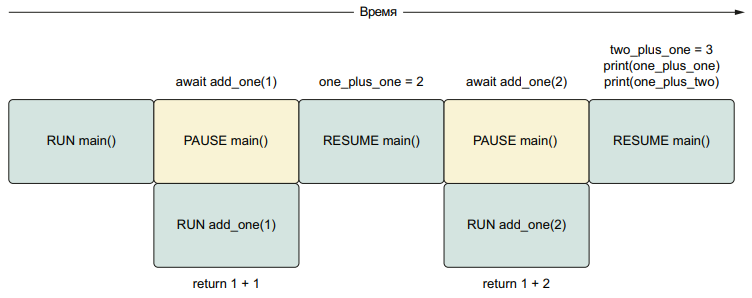

Встретив выражение `await`, интерпретатор приостанавливает родительскую
сопрограмму и выполняет сопрограмму в выражении `await`. По ее завершении
родительская сопрограмма приостанавливается и возвращенное ей значение присваивается переменной.

Этот код работает так же, как обычный последовательный код. По существу, мы имитируем обычный стек вызовов.

### Длительные операции

Чтобы в полной мере прочувствовать все преимущества и показать, как обрабатывать несколько событий одновременно, нам нужны какие-то длительные операции. Вместо того, чтобы отправлять сложные веб-запросы к серверам или запросы к базе данных, мы можем просто смоделировать длительную операцию с помощью функции `asyncio.sleep`.

Функция `asyncio.sleep` заставляет сопрограмму «заснуть» на заданное число секунд, т. е. приостанавливает ее на заданное время.

Это позволяет смоделировать, что происходит при обращении к базе данных или веб-ресурсу.

> `asyncio.sleep` уже является сопрограммой, поэтому вызывать ее следует с помощью await.

Вызвав ее напрямую, мы получим просто объект сопрограммы. Раз asyncio.sleep – сопрограмма, то, пока мы ее ждем, может выполняться другой код.

Приведем простой пример, напишем простую программу, которая после запуска будет засыпать на 1 секунду, а после печатать сообщение «Hello World!».

In [ ]:
import asyncio
async def hello_world_message() -> str:
    await asyncio.sleep(1) # приостанавливаем hello_world_message на 1 сек.
    return 'Hello World!'

async def main() -> None:
    message = await hello_world_message() # приостанавливаем main до завершения hello_world_message
    print(message)

asyncio.run(main())

Hello World!


Эта программа ждет 1 секунду, а затем печатает сообщение «Hello World!».
Поскольку `hello_world_message` – сопрограмма, а мы приостановили ее на 1 секунду, у нас появилась одна секунда, в течение которой мог бы конкурентно работать другой код.

Попробуем заставить простое сложение работать конкурентно, пока `hello_world_message` приостановлена:

In [ ]:
import asyncio

async def add_one(number: int) -> int:
    print(f'математические вычисления')
    return number + 1

async def hello_world_message() -> str:
    print(f'засыпаю на 1 с')
    await asyncio.sleep(1)
    print(f'просыпаюсь!')
    return 'Hello World!'

async def main() -> None:
    message = await hello_world_message()
    one_plus_one = await add_one(1)
    print(one_plus_one)
    print(message)

asyncio.run(main())

засыпаю на 1 с
просыпаюсь!
математические вычисления
2
Hello World!


При выполнении этого кода проходит 1 с, прежде чем будут напечатаны результаты обеих функций. Мы же хотели, чтобы значение `add_one(1)` было напечатано немедленно, пока `hello_world_message()` работает конкурентно.

**И что же не так с этим кодом?**

Дело в том, что `await` приостанавливает текущую сопрограмму и код внутри нее не
выполняется, пока выражение `await` не вернет значение. Поскольку `hello_world_message` вернет значение только через секунду, сопрограмма `main` на эту секунду и приостанавливается. В данном случае код ведет себя как последовательный:

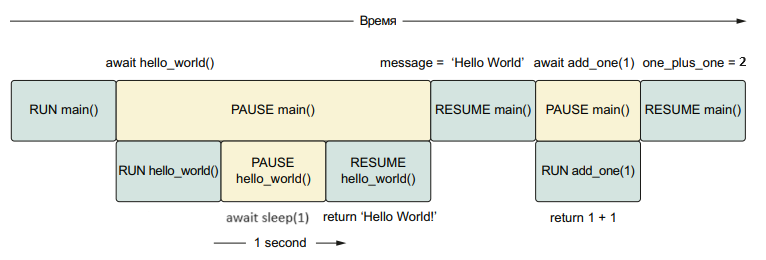

И `main`, и `hello_world` приостановлены в ожидании завершения `sleep(1)`. А когда это произойдет, то `main` возобновится и выполнит `add_one`.

Нам хотелось бы уйти от этой последовательной модели и выполнять `add_one` конкурентно с `hello_world`.

Для этого перейдем к рассмотрению концепции задач.

## Конкурентное выполнение с помощью задач

### Создание задач

Ранее мы видели, что непосредственный вызов сопрограммы не передает ее циклу событий для выполнения. Вместо этого мы получаем объект сопрограммы, который нужно затем использовать совместно с ключевым словом `await` или передать функции `asyncio.run`, чтобы получить возвращенное значение.

Располагая только этими инструментами, мы можем написать асинхронный код, но не можем выполнить его конкурентно. А чтобы это сделать, нужны задачи.

**Задача** – это обертка вокруг сопрограммы, которая планирует ее выполнение в цикле событий как можно раньше. И планирование, и выполнение происходят в неблокирующем режиме, т. е., создав задачу, мы можем сразу приступить к выполнению другого кода, пока эта задача работает в фоне.

Сравните с ключевым словом `await`, которое блокирует выполнение, т. е. мы приостанавливаем всю сопрограмму на время, пока выражение `await` не вернет управление.

Способность создавать задачи и планировать их для немедленного
выполнения в  цикле событий означает, что несколько задач может
работать приблизительно в одно и то же время. Пока одна задача выполняет длительную операцию, другие могут работать конкурентно.
Для иллюстрации создадим две задачи и  попробуем выполнить их
одновременно.


Для создания задачи служит функция `asyncio.create_task`. Ей передается подлежащая выполнению сопрограмма, а в ответ она немедленно возвращает объект задачи. Этот объект можно включить в выражение `await`, которое извлечет возвращенное значение по завершении задачи.

In [ ]:
import asyncio

# Сопрограмма засыпания
async def delay(delay_seconds: int) -> int:
    print(f'засыпаю на {delay_seconds} сек.')
    await asyncio.sleep(delay_seconds)
    print(f'сон в течение {delay_seconds} сек. закончился')
    return delay_seconds


async def main():
    # Создаем задачу
    sleep_for_three = asyncio.create_task(delay(3))
    print(type(sleep_for_three))
    result = await sleep_for_three
    print(result)

# Запускаем цикл событий
asyncio.run(main())

<class 'asyncio.tasks.Task'>
засыпаю на 3 сек.
сон в течение 3 сек. закончился
3


Таким образом, мы создали задачу, которой для выполнения нужно 3 секунды. Кроме того, мы печатаем тип задачи, чтобы показать, что это не сопрограмма. Видно, что сообщение напечаталось сразу после запуска задачи. Если бы мы просто использовали `await` для сопрограммы `delay`, то увидели бы сообщение только через 3 секунды.

Напечатав сообщение с типом задачи, мы применяем `await` к  задаче `sleep_for_three`. Это приостанавливает сопрограмму main до получения результата от задачи.

Если бы мы не добавили await перед задачей, то задача была бы запланирована, но почти сразу остановлена, а когда `asyncio.run` завершит бы цикл событий, интерпретатор бы очистил все ресурсы, выделенные под задачу.

Познакомившись с тем, как создавать задачи и конкурентно
запускать другой код, посмотрим, как можно одновременно выполнять несколько длительных операций.

### Создание и управление несколькими конкурентными задачами

Мы уже знаем, что задачи создаются мгновенно и планируются для выполнения как можно раньше, а значит мы получаем возможность конкурентно выполнять несколько длительных задач. Для этого нужно последовательно запустить несколько задач в одной долго работающей сопрограмме.


In [ ]:
import asyncio

# Сопрограмма засыпания
async def delay(delay_seconds: int) -> int:
    print(f'засыпаю на {delay_seconds} сек.')
    await asyncio.sleep(delay_seconds)
    print(f'сон в течение {delay_seconds} сек. закончился')
    return delay_seconds

async def main():
    # Запланируем три задачи по 3 секунды выполнения
    sleep_for_three = asyncio.create_task(delay(3))
    sleep_again = asyncio.create_task(delay(3))
    sleep_once_more = asyncio.create_task(delay(3))

    # Запустим задачи
    await sleep_for_three
    await sleep_again
    await sleep_once_more

# Запускаем цикл событий
asyncio.run(main())


засыпаю на 3 сек.
засыпаю на 3 сек.
засыпаю на 3 сек.
сон в течение 3 сек. закончился
сон в течение 3 сек. закончился
сон в течение 3 сек. закончился


Мы запустили три задачи, каждой из которых для завершения нужно 3 секунды.

Каждое обращение к `create_task` возвращает управление немедленно, поэтому до предложения `await sleep_for_three` мы доходим сразу же. Ранее мы отмечали, что выполнение задач планируется «как можно раньше». На практике это означает, что в точке, где встречается первое после создания задачи предложение `await`, все
ожидающие задачи начинают выполняться, так как `await` запускает очередную итерацию цикла событий.

Поскольку первым мы встречаем предложение `await sleep_for_three`, все три задачи начинают выполняться и засыпают одновременно. Значит, программа завершится примерно через 3 секунды.

Посмотрите на поток выполнения команды, все три задачи исполняют свои сопрограммы `sleep` в одно и то же время:

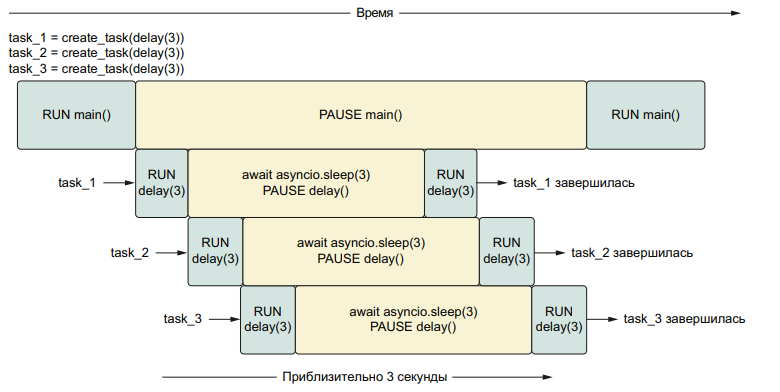

Код в  задачах, который помечен как **RUN delay(3)** (в данном случае вызовы `print`), не работает конкурентно с другими задачами.

Если бы мы выполняли операции задержки последовательно, то программа работала бы дольше 9 секунд. А конкурентность позволила уменьшить время работы почти в три раза! Причем это преимущество конкурентности растет по мере увеличения
числа задач. Если бы мы запустили 10 таких задач, то программа работала бы те же 3 секунды, что дало бы 10-кратное ускорение.

Конкурентное выполнение таких длительных операций  – как раз та область, где `asyncio` блистает и резко улучшает производительность приложения, но на этом преимущества не заканчиваются.

Наше асинхронное приложение в активно било баклуши, в течение трех секунд, ожидая истечения времени задержки. Но пока один код ожидает, можно было бы
выполнить другой. Допустим, мы хотим один раз в секунду выводить сообщения о состоянии, пока какие-то длительные задачи работают.

In [ ]:
import asyncio

# Сопрограмма засыпания
async def delay(delay_seconds: int) -> int:
    print(f'засыпаю на {delay_seconds} сек.')
    await asyncio.sleep(delay_seconds)
    print(f'сон в течение {delay_seconds} сек. закончился')
    return delay_seconds


async def hello_every_second():
    for i in range(2):
        await asyncio.sleep(1)
        print("пока я жду 1 сек., исполняется другой код!")


async def main():
    first_delay = asyncio.create_task(delay(3))
    second_delay = asyncio.create_task(delay(3))

    await hello_every_second()
    await first_delay
    await second_delay

# Запускаем цикл событий
asyncio.run(main())

засыпаю на 3 сек.
засыпаю на 3 сек.
пока я жду 1 сек., исполняется другой код!
пока я жду 1 сек., исполняется другой код!
сон в течение 3 сек. закончился
сон в течение 3 сек. закончился


Здесь мы создаем две задачи, работающие по 3 секунды. Пока эти задачи ждут, приложение простаивает, что дает нам возможность занять его другим кодом. В этом примере выполняется сопрограмма `hello_every_second`, которая дважды печатает сообщение с интервалом в одну секунду. Пока две задачи что-то делают, мы видим, как печатаются эти сообщения.



Посмотрим на поток выполнения нашей программы:

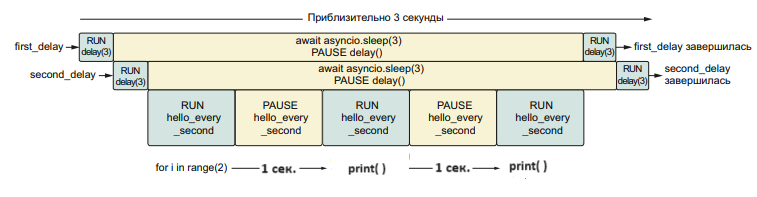

Сначала мы запускаем две задачи, которые спят в течение 3 секунд. Пока
эти задачи простаивают, мы видим, как каждую секунду печатается сообщение *«пока я жду 1 сек., исполняется другой код!»*. Это означает, что даже во время выполнения длительных операций наше приложение может выполнять другие задачи.
Потенциальная проблема заключается в том, что задача может работать неопределенно долго. Быть может, нам захочется остановить задачу, если она никак не кончается сама. Такая возможность поддерживается и называется снятием.

### Снятие задач и тайм-ауты

Сетевые подключения ненадежны. Установленное пользователем подключение может быть разорвано из-за медленной сети, или веб-сервер может «упасть» и оставить существующие запросы в подвешенном состоянии. Поэтому, отправляя запросы, мы должны внимательно следить за ними, чтобы не ждать слишком долго. Иначе приложение может зависнуть, ожидая результата, который никогда не придет.

То есть, сли бы задачи работали вечно, то мы бы застряли в предложении `await` без всякой обратной связи. И остановить бы программу не смогли, даже если бы захотели. В библиотеке `asyncio` предусмотрены обе ситуации – мы можем **снять задачу** или **задать тайм-аут**.


#### Снятие задач

Снять задачу просто. У каждого объекта задачи есть метод `cancel`, который можно вызвать, если требуется остановить задачу. В результате снятия задача вызовет исключение `CancelledError`, когда мы ждем ее с помощью `await`. Это исключения можно обработать, как того требует ситуация.

Для иллюстрации предположим, что мы запустили задачу, которая не должна работать дольше 5 с. Если за это время задача не завершилась, то мы хотим ее снять, сообщив пользователю, что задача работает слишком долго и  будет остановлена. Мы также хотим каждую секунду печатать сообщение о состоянии, чтобы держать пользователя в курсе, а не оставлять в неведении на протяжении нескольких секунд.

In [ ]:
import asyncio
from asyncio import CancelledError

# Сопрограмма засыпания
async def delay(delay_seconds: int) -> int:
    print(f'засыпаю на {delay_seconds} сек.')
    await asyncio.sleep(delay_seconds)
    print(f'сон в течение {delay_seconds} сек. закончился')
    return delay_seconds

# Главная сопрограмма
async def main():
    # Очень долгая задача
    long_task = asyncio.create_task(delay(10))

    # счетчик наблюдений за задачей
    seconds_elapsed = 0

    # пока задача не завершена наблюдаем за ней
    while not long_task.done():
        print('Задача не закончилась, следующая проверка через секунду.')
        await asyncio.sleep(1)

        seconds_elapsed = seconds_elapsed + 1
        if seconds_elapsed == 5:
            # снимаем задачу по счетчику
            long_task.cancel()

    # запускаем задачу в обработчике ошибок
    try:
        # пока нет ошибки задача выполняется
        await long_task
    except CancelledError:
        # в случае ошибки сообщаем пользователю
        print('Наша задача была снята')

# Запускаем цикл событий
asyncio.run(main())

Задача не закончилась, следующая проверка через секунду.
засыпаю на 10 сек.
Задача не закончилась, следующая проверка через секунду.
Задача не закончилась, следующая проверка через секунду.
Задача не закончилась, следующая проверка через секунду.
Задача не закончилась, следующая проверка через секунду.
Задача не закончилась, следующая проверка через секунду.
Наша задача была снята


Таким образом, мы создали задачу, которая работает 10 секунд. Затем в  цикле `while` проверяем состояние задачи. Метод задачи `done` возвращает `True`,
если задача завершилась, и `False` в  противном случае. Каждую секунду мы проверяем, завершилась ли задача, и запоминаем, сколько секунд уже прошло. Если задача работает дольше 5 секунд, то мы ее снимаем. Далее задача запускается в предложении `await long_task` и, если возникло исключение `CancelledError`, печатается сообщение *«Наша задача была снята»*.

Важно отметить, что исключение `CancelledError` может быть вызвано только внутри предложения `await`. То есть, если вызвать метод `cancel`, когда задача исполняет Python-код, этот код будет продолжать работать, пока не встретится следующее предложение `await`, если встретится, и только тогда будет вызвано исключение `CancelledError`.

Вызов `cancel` не прерывает задачу, делающую свое дело, а снимает ее, только если она уже находится в точке ожидания или когда дойдет до следующей такой точки.

#### Установка тайм-аута

Проверять состояние каждую секунду или с другим интервалом, как в предыдущем примере, – не самый простой способ реализации таймаута. В идеале хотелось бы иметь вспомогательную функцию, которая позволяла бы задать тайм-аут и снять задачу по его истечении.

В `asyncio` есть такая возможность в виде функции `asyncio.wait_for`.

Она принимает объект сопрограммы или задачи и тайм-аут в секундах и  возвращает сопрограмму, к которой можно применить `await`.

Если задача не завершилась в отведенное время, то вызывается исключение `TimeoutError` и задача автоматически снимается.

Для иллюстрации работы `wait_for` мы рассмотрим случай, когда задаче требуется две секунды, но мы даем ей только одну. Мы перехватываем исключение  `TimeoutError` и смотрим, была ли задача снята.

In [ ]:
import asyncio

# Сопрограмма засыпания
async def delay(delay_seconds: int) -> int:
    print(f'засыпаю на {delay_seconds} сек.')
    await asyncio.sleep(delay_seconds)
    print(f'сон в течение {delay_seconds} сек. закончился')
    return delay_seconds

# Главная сопрограмма
async def main():
    # Создаем задачу
    delay_task = asyncio.create_task(delay(2))

    try:
        # Запускаем задачу и устанавливаем тайм-аут
        result = await asyncio.wait_for(delay_task, timeout=1)
        print(result)
    except asyncio.exceptions.TimeoutError:
        print('Тайм-аут!')
        # Проверяем была ли снята задача
        print(f'Задача была снята? {delay_task.cancelled()}')

# Запускаем цикл событий
asyncio.run(main())

засыпаю на 2 сек.
Тайм-аут!
Задача была снята? True


Автоматическое снятие задачи, работающей дольше, чем ожидается, обычно является разумной практикой. В противном случае сопрограмма могла бы ждать неопределенно долго, занимая ресурсы, которые никогда не будут освобождены. Но в некоторых случаях желательно дать сопрограмме поработать. Например, по прошествии некоторого времени мы можем проинформировать пользователя о том, что работа занимает дольше, чем ожидалось, но не снимать ее, когда тайм-аут истечет.

Для этого обернем нашу задачу функцией `asyncio.shield`. Эта функция предотвращает снятие сопрограммы, снабжая ее «щитом», позволяющим игнорировать запросы на снятие.

In [ ]:
import asyncio

# Сопрограмма засыпания
async def delay(delay_seconds: int) -> int:
    print(f'засыпаю на {delay_seconds} сек.')
    await asyncio.sleep(delay_seconds)
    print(f'сон в течение {delay_seconds} сек. закончился')
    return delay_seconds

# Главная сопрограмма
async def main():
    # Очень долгая задача
    task = asyncio.create_task(delay(10))

    try:
        # оборачиваем задачу в "защитник"
        result = await asyncio.wait_for(asyncio.shield(task), 5)
        print(result)
    except asyncio.exceptions.TimeoutError:
        print("Задача заняла более 5 сек, скоро она закончится!")

        # результат выполнения сопрограммы выводим на печать
        result = await task
        print(result)


# Запускаем цикл событий
asyncio.run(main())

засыпаю на 10 сек.
Задача заняла более 5 сек, скоро она закончится!
сон в течение 10 сек. закончился
10


Обратите внимание, что в блоке `except` мы обращаемся к задаче, чтобы получить результат выполнения сопрограммы `delay`, которая возвращает время, на которое засыпала задача. Затем внутри блока `try` мы вызываем `wait_for`, обернув предварительно задачу функцией `shield`, чтобы она не была снята. В блоке обработки исключения мы печатаем полезное сообщение пользователю, в котором говорим, что задача еще работает, после чего ждем ее завершения с помощью `await`. Это позволит задаче продолжить выполнение, а пользователю получить сообщение от программы и убедиться, что она не "зависла".

## Будущие объекты

И сопрограммы, и задачи можно использовать в выражениях `await`.

**Так что же между ними общего?**

Чтобы ответить на этот вопрос, нужно знать о типах `future` и `awaitable`.

На практике будущие объекты (`future`, или футуры) бывают нужны редко, но иметь о них общее представление необходимо, если мы хотим понять, как работает `asyncio`.

Объект `future` в Python содержит одно значение, которое мы ожидаем получить в будущем, но пока еще, возможно, не получили. Обычно `asyncio` в момент создания `future` не обертывает никакого значения, потому что его еще не существует.

Объект в таком состоянии называется неполным, неразрешенным или просто неготовым. И только получив результат, мы можем установить значение объекта `future`, в результате чего он становится полным и из него можно извлечь результат.

Чтобы лучше разобраться со всем этим, создадим будущий объект, установим его значение и затем извлечем его.


In [ ]:
from asyncio import Future

my_future = Future()

print(f'my_future готов? {my_future.done()}')

my_future.set_result(42)

print(f'my_future готов? {my_future.done()}')
print(f'Какой результат хранится в my_future? {my_future.result()}')

my_future готов? False
my_future готов? True
Какой результат хранится в my_future? 42


**ВАЖНО**. Мы не вызываем метод `result`, прежде чем результат установлен, потому что тогда он вызвал бы исключение `InvalidState`.

Для создания объекта `future` нужно вызвать его конструктор. В этот момент во `future` нет никакого результата, поэтому вызов метода `done` возвращает `False`. Затем мы устанавливаем значение `future` методом `set_result`, который помечает его как готовый. Если бы вместо этого мы хотели записать во `future` исключение, то вызвали бы метод `set_exception`.

Будущие объекты также можно использовать в выражениях `await`. Это означает:

```
«я посплю, пока в будущем объекте не будет установлено значение,
с которым я могу работать, а когда оно появится, разбуди меня
и дай возможность его обработать»
```

Например, отправка веб-запроса возвращает объект `future`. В этом случае `future` возвращается немедленно, но, поскольку запрос занимает некоторое время, значение `future` еще не определено. Позже, когда запрос завершится, результат будет установлен, и мы сможем его получить. Те, кто знаком с `JavaScript`, легко увидят аналогию с обещаниями (`promise`). В `Java` похожая концепция называется дополняемыми будущими объектами (`completable future`).

В `asyncio` редко приходится иметь дело с будущими объектами. Поэтому мы не будем в них погружаться.

Отметим лишь тесную связь между задачами и будущими объектами. На самом деле `task` напрямую наследует `future`. Можно считать, что объект `future` представляет значение, которое появится только в  будущем. А `task` является комбинацией сопрограммы и `future`.

Создавая задачу, мы создаем пустой объект `future` и запускаем сопрограмму.
А  когда сопрограмма завершится с  результатом или вследствие исключения, мы записываем этот результат или объект-исключение во `future`.

На самом деле существует аналогичная связь и между задачами и сопрограммами. Ведь все эти типы можно использовать в выражениях `await`. Связующим звеном между ними является абстрактный базовый класс `Awaitable`. В нем определен единственный абстрактный метод `__await__`. Любой объект, который реализует метод `__await__`, можно использовать в выражении `await`. Сопрограммы, как и будущие объекты, наследуют `Awaitable` напрямую.

## Подведем итоги

В данном Блокноте мы:

* научились создавать сопрограммы с помощью ключевого слова `async`. Сопрограмма может приостанавливать себя, встретив блокирующую операцию. Это дает возможность поработать другим сопрограммам. После завершения операции, на которой сопрограмма приостановилась, она пробуждается и продолжает работу
с прерванного места.

* узнали, что вызову сопрограммы должно предшествовать ключевое слово `await`, означающее, что нужно дождаться возврата значения. При этом сопрограмма, внутри которой встретилось слово `await`, приостанавливается в ожидании результата. В это время могут работать другие сопрограммы.

* узнали, как использовать функцию `asyncio.run` для выполнения одной сопрограммы, являющейся точкой входа в приложение.

* научились использовать задачи для конкурентного выполнения нескольких длительных операций. Задачи – это обертки вокруг сопрограмм, которые исполняются в цикле событий. Созданная задача планируется для выполнения как можно раньше.

* узнали, как снимать задачу, когда нужно остановить ее, и как задать тайм-аут, чтобы задача не работала бесконечно долго. После снятия задачи возбуждается исключение `CancelledError`, когда мы ожидаем результат. Если имеются ограничения на время работы задачи, то можно задать тайм-аут в методе `asycio.wait_for`.


В качестве закрепления материала рекомендуется ознакомиться с [задачами](https://colab.research.google.com/drive/1N1gjxDRZPzeR7aL4sBnOSFE8qg9Zf_tM) по асинхронному программированию, прежде чем перейти к следующей части урока. Решение задач не является обязательным условием для прохождения урока, но позволит вам самим понять насколько вы готовы ворваться в безжалостный мир асинхронного программирования.

Теперь, когда мы знаем все необходимое об асинхронном программировании, то [пора переходить](https://colab.research.google.com/drive/1bgS8Uuqi2jrhqDAyaMmxhbOLJ3TvmKFC) к изучению асинхронной библиотеке `aiogram3` и уже начинать создавать своего первого Telegram-бота.